In [1]:
from scipy.cluster.hierarchy import dendrogram
import scipy.spatial.distance

from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import AgglomerativeClustering, KMeans, k_means
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("2021.csv")
matrix = df[["Healthy life expectancy", "Ladder score"]]

In [3]:
# Inertia scores to choose a good cluster number
inertia_scores = []
svd = TruncatedSVD(n_components=1)
svd.fit(matrix)

matrix_reduced_pt2 = svd.transform(matrix)

      k        score
0     2  1818.572124
1     3   881.639852
2     4   475.674423
3    10    82.445947
4    11    67.060323
5    12    56.607111
6    27     6.512418
7    28     5.685754
8    39     2.613046
9    45     1.752149
10   48     1.442010
11   52     1.015611
12   53     0.988691
13   55     0.851161
14   56     0.833956
15   59     0.652669
16   60     0.590804
17   61     0.565186
18   65     0.409213
19   76     0.214075
20   80     0.175438
21   83     0.139966
22   84     0.129165
23   91     0.073022
24   93     0.064377
25   97     0.049259
26   98     0.044725
27  110     0.019268


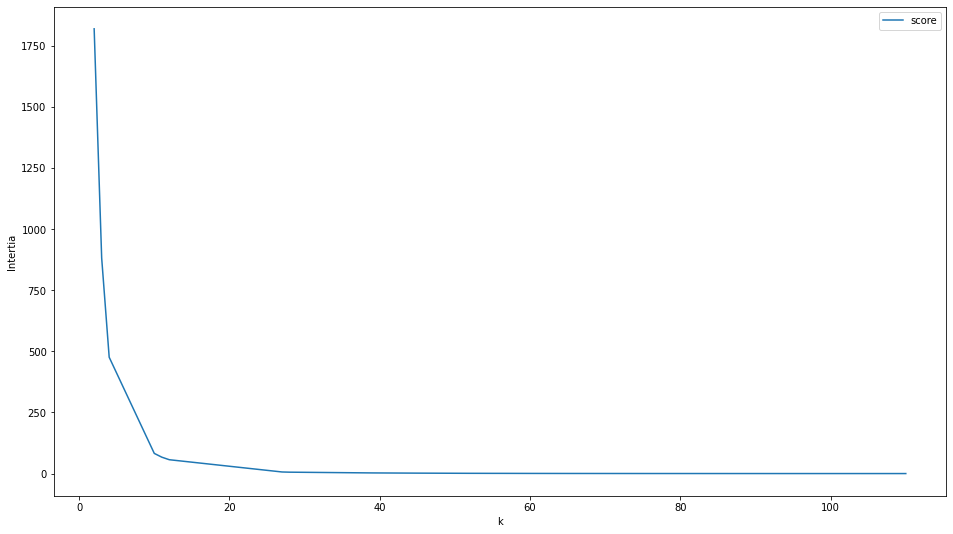

In [4]:
# redo clustering with random k values
inertia_scores = []
for test_k in set(np.random.randint(2, 120, 30)):

    tmp_model = KMeans(n_clusters=test_k)
    tmp_model.fit(matrix_reduced_pt2)

    score = tmp_model.inertia_
    inertia_scores.append((test_k, score))
intertia_df = pd.DataFrame(inertia_scores, columns=["k", "score"])
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(1, 1, 1)

intertia_df.sort_values(by="k").plot("k", "score", ax=ax)
print(intertia_df)
ax.set_ylabel("Intertia")
plt.show()  # "Elbow" graph

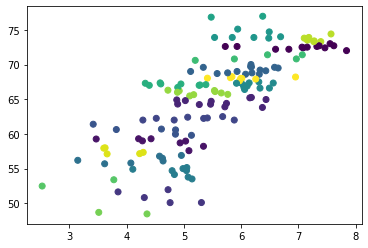

CLUSTER: 0
      Country name Regional indicator  Healthy life expectancy  Ladder score
0          Finland     Western Europe                   72.000         7.842
1          Denmark     Western Europe                   72.700         7.620
3          Iceland     Western Europe                   73.000         7.554
4      Netherlands     Western Europe                   72.400         7.464
6           Sweden     Western Europe                   72.700         7.363
7       Luxembourg     Western Europe                   72.600         7.324
12         Germany     Western Europe                   72.500         7.155
14         Ireland     Western Europe                   72.400         7.085
16  United Kingdom     Western Europe                   72.500         7.064
19         Belgium     Western Europe                   72.199         6.834
22           Malta     Western Europe                   72.200         6.602
57        Portugal     Western Europe                   72.600   

In [5]:
# uncomment KMeans(..) and comment AgglomerativeClustering(...) to choose between the two models
# model = KMeans(n_clusters=20)
num_clusters = 20  # 20 is from inertia score/elbow graph estimate
model = AgglomerativeClustering(n_clusters=num_clusters)
model.fit(matrix)
df["cluster"] = model.labels_

plt.scatter(matrix["Ladder score"],
            matrix["Healthy life expectancy"], c=df["cluster"])
plt.show()  # scatterplot


counter = 0
while counter < num_clusters:
    df2 = df.loc[df["cluster"] == counter]
    print("CLUSTER:", counter)
    print(df2[["Country name", "Regional indicator",
          "Healthy life expectancy", "Ladder score"]])
    print(df2["Regional indicator"].value_counts())
    counter += 1

In [6]:
# measure similiarity with in the cluster 19
newdf = df.set_index('Country name')
newdf = df.loc[df["cluster"] == 19]
newdf = newdf[["Healthy life expectancy", "Ladder score"]]

newdf["points"] = list(
    zip(newdf["Healthy life expectancy"], newdf["Ladder score"]))
points = newdf["points"].values.tolist()


sim = scipy.spatial.distance.cdist(points, points, 'euclidean')
cluster_list = ['United States', 'Lithuania', "Colombia", "Hungary",
                "Nicaragua", "Peru", "Bosnia and Herzegovina", "Vietnam"]
simdf = pd.DataFrame(sim, columns=cluster_list)
simdf["Country Name"] = cluster_list
simdf = simdf.set_index("Country Name")
print(simdf)

                        United States  Lithuania  Colombia   Hungary  \
Country Name                                                           
United States                0.000000   0.755547  0.959855  0.979633   
Lithuania                    0.755547   0.000000  0.260910  0.279294   
Colombia                     0.959855   0.260910  0.000000  0.020025   
Hungary                      0.979633   0.279294  0.020025  0.000000   
Nicaragua                    1.119504   0.376948  0.346318  0.343583   
Peru                         1.112125   0.539037  0.302630  0.292582   
Bosnia and Herzegovina       1.142562   0.481900  0.221382  0.204071   
Vietnam                      1.548921   0.853651  0.601905  0.581994   

                        Nicaragua      Peru  Bosnia and Herzegovina   Vietnam  
Country Name                                                                   
United States            1.119504  1.112125                1.142562  1.548921  
Lithuania                0.376948  0.53

In [7]:
# Dendrogram to show hierarchy of AgglomerativeClustering
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

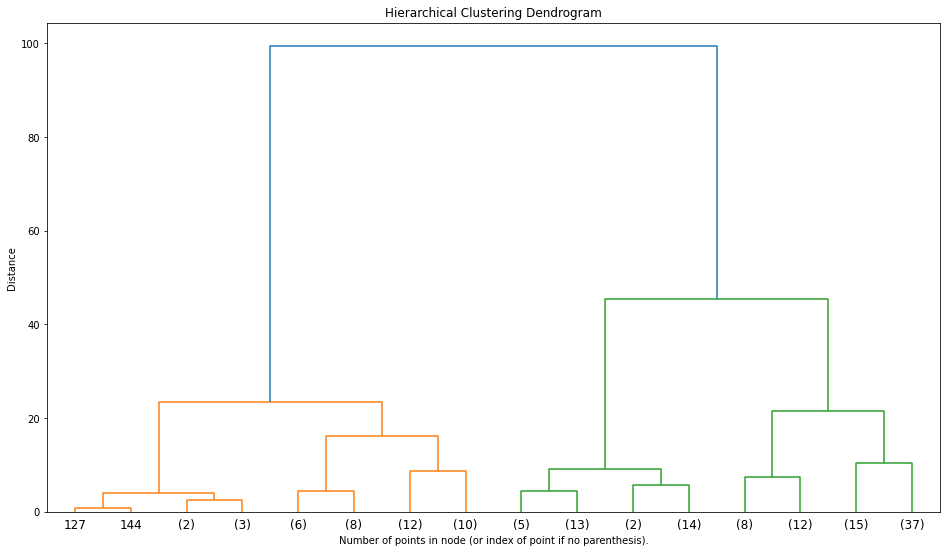

In [8]:
# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(matrix)
fig = plt.figure(figsize=(16, 9))
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode="level", p=3)
plt.ylabel("Distance")
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()